In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import wisps
import wisps.simulations as wispsim
from theano.compile.ops import as_op
import theano.tensor as tt
import scipy.integrate as integrate
import astropy.units as u
%matplotlib inline

In [2]:
lf=pd.read_pickle(wisps.OUTPUT_FILES+'/lf.pkl')

In [3]:
domega=4.1*(u.arcmin**2).to(u.radian**2)

In [4]:
Rsun=83000.
Zsun=27.

def density_function(r, z, h=300.):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    zpart=np.exp(-abs(z-Zsun)/h)
    rpart=np.exp(-(r-Rsun)/l)
    return zpart*rpart

def custom_volume(l,b,dmin, dmax, h):
    nsamp=1000
    ds = np.linspace(dmin,dmax,nsamp)
    rd=np.sqrt( (ds * np.cos( b ) )**2 + Rsun * (Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
    zd=Zsun+ ds * np.sin( b - np.arctan( Zsun / Rsun) )
    rh0=density_function(rd, zd,h=h )
    val=np.trapz(rh0*(ds**2), x=ds)
    return val

def easy_non_integral_volume(l, b, dmin, dmax, h):
    #this avoids integrals, to be used in likelhood methods like pymc
    nsamp=100
    ds = np.linspace(dmin,dmax,nsamp)
    rd=np.sqrt( (ds * np.cos( b ) )**2 + Rsun * (Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
    zd=Zsun+ ds * np.sin( b - np.arctan( Zsun / Rsun) )
    rh0=density_function(rd, zd,h=h )
    return np.nansum(rh0*ds**3)
    

def interpolated_lf(spt):
    sortedindex=np.argsort(lf['spt'])
    xs=lf['spt']
    ys=lf['phi']
    val=np.interp(spt,  xs[sortedindex], ys[sortedindex])
    return val

def bin_in_five_subtypes(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 42]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def compute_volume(h):
    vs=[]
    for s in wispsim.SPGRID:
        dmax, dmin=DLIMITS[s]
        vls=[]
        for l, b in lbs:
            vls.append(easy_non_integral_volume(l,b,dmin, dmax, h))
        vs.append(np.nansum(vls))
    return vs

    

In [5]:
interpolated_lf_values=interpolated_lf(wispsim.SPGRID)

In [6]:
pnts=wisps.OBSERVED_POINTINGS
lbs=[[pnt.coord.galactic.l.radian,pnt.coord.galactic.b.radian] for pnt in pnts]

In [7]:
DLIMITS=pnts[0].dist_limits

In [8]:
NOBS=np.array([148, 26, 3, 12, 2])

In [9]:
#@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def lnlike(h):
    vol=np.array(compute_volume(h))*domega
    nsim=np.array(bin_in_five_subtypes(wispsim.SPGRID, (vol*interpolated_lf_values)))
    #compute chi-square
    nobs_err=np.sqrt(NOBS)
    chi_square=np.nansum((nsim-NOBS)**2/(nobs_err**2))
    return -chi_square*0.5

def lnprior(h):
    if 10.0 < h < 1000.:
        return 0.0
    return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [10]:
#forget pymc, doesn't work well with integrals
with pm.Model() as model:
    h=pm.Uniform('h', lower=100, upper=1000)
    like = pm.DensityDist('like', lnlike, observed={'h': h})
    trace = pm.sample(draws=100, cores=2, step=pm.Metropolis())

KeyboardInterrupt: 

In [12]:
ndim, nwalkers = 1, 100
pos = [ 1000*np.random.randn(ndim) for i in range(nwalkers)]
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [ ]:
#ugh very slow probably won't converge


In [ ]:
samples=sampler.run_mcmc(pos, 1000)

In [23]:
sampl = sampler.chain.flatten()

(array([  600.,   800.,  1054.,  1928.,   219., 14472.,   338.,    75.,
          387.,   127.]),
 array([-2659.69274494, -2148.18375678, -1636.67476862, -1125.16578046,
         -613.65679231,  -102.14780415,   409.36118401,   920.87017217,
         1432.37916032,  1943.88814848,  2455.39713664]),
 <a list of 10 Patch objects>)

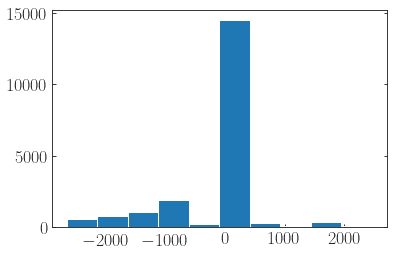

In [25]:
plt.hist(sampl)